In [ ]:
GA-Grundgerüst (für beide Probleme)

In [189]:
# == GA CORE ===============================================================
import random, time
from dataclasses import dataclass

@dataclass
class GAConfig:
    pop_size: int = 200
    max_generations: int = 2000
    crossover_rate: float = 0.9
    mutation_rate: float = 0.2
    tournament_k: int = 3
    elitism: int = 2  # wie viele Top-Individuen direkt übernehmen
    seed: int | None = None

def tournament_select(pop, fitness_fn, k):
    """Wählt 1 Individuum per k-Turnier (höhere Fitness gewinnt)."""
    cand = random.sample(pop, k)
    cand.sort(key=fitness_fn, reverse=True)
    return cand[0]

def one_point_crossover(a, b):
    """Einpunkt-Crossover, gibt zwei Kinder zurück (gleiche Länge wie Eltern)."""
    assert len(a) == len(b)
    if len(a) < 2:
        return a[:], b[:]
    cut = random.randint(1, len(a) - 1)
    return a[:cut] + b[cut:], b[:cut] + a[cut:]

def mutate_indexed(indiv, domain_per_index, mutation_rate):
    """
    Mutiert jedes Gen mit Wahrscheinlichkeit mutation_rate.
    domain_per_index: Liste von aufrufbaren Funktionen oder Listen:
      - Wenn callable(i): gibt einen zulässigen Wert für index i zurück
      - Wenn Liste: zufälliger Wert aus dieser Liste, != current (falls möglich)
    """
    x = indiv[:]
    for i in range(len(x)):
        if random.random() < mutation_rate:
            domain = domain_per_index[i]
            if callable(domain):
                x[i] = domain(i)
            else:
                # Liste: wähle neuen Wert, nach Möglichkeit != alter
                choices = domain[:]
                if len(choices) > 1:
                    choices = [v for v in choices if v != x[i]] or domain
                x[i] = random.choice(choices)
    return x

def run_ga(
    init_population_fn,
    fitness_fn,
    domain_per_index,
    config: GAConfig,
    is_solution_fn=None,
    crossover_fn=one_point_crossover,
):
    """
    Führt GA aus und gibt (best_indiv, best_fit, generations, evals, elapsed_s) zurück.
    - init_population_fn(): Liste von Individuen (gleiche Länge)
    - fitness_fn(indiv): float (höher = besser)
    - domain_per_index: siehe mutate_indexed()
    - is_solution_fn(indiv) -> bool (optional für frühzeitigen Stopp)
    """
    if config.seed is not None:
        random.seed(config.seed)

    pop = init_population_fn()
    fitness_cache = {}
    def F(ind):
        k = tuple(ind)
        if k not in fitness_cache:
            fitness_cache[k] = fitness_fn(ind)
        return fitness_cache[k]

    t0 = time.time()
    evals = 0

    # Helper: bestes Individuum der Population
    def best_of(pop):
        bf = None; bi = None
        for ind in pop:
            f = F(ind);
            evals_nonlocal[0] += 1
            if bf is None or f > bf: bf, bi = f, ind
        return bi, bf

    evals_nonlocal = [0]  # trick für closure-Zugriff
    best_ind, best_fit = None, float("-inf")

    for gen in range(config.max_generations + 1):
        # Elite sichern
        pop.sort(key=F, reverse=True)
        evals += len(pop)  # F() wurde für sort aufgerufen
        elites = pop[:config.elitism]

        # Frühstopp, sofern echte Lösung gefunden
        if is_solution_fn and is_solution_fn(elites[0]):
            best_ind, best_fit = elites[0], F(elites[0])
            break

        # Neue Population erzeugen
        new_pop = elites[:]
        while len(new_pop) < config.pop_size:
            p1 = tournament_select(pop, F, config.tournament_k)
            p2 = tournament_select(pop, F, config.tournament_k)
            c1, c2 = p1[:], p2[:]
            if random.random() < config.crossover_rate:
                c1, c2 = crossover_fn(p1, p2)

            c1 = mutate_indexed(c1, domain_per_index, config.mutation_rate)
            if len(new_pop) < config.pop_size:
                new_pop.append(c1)
            if len(new_pop) < config.pop_size:
                c2 = mutate_indexed(c2, domain_per_index, config.mutation_rate)
                new_pop.append(c2)

        pop = new_pop

        # Fortschritt tracken
        pop.sort(key=F, reverse=True)
        evals += len(pop)
        if F(pop[0]) > (best_fit if best_ind is not None else float("-inf")):
            best_ind, best_fit = pop[0], F(pop[0])

        # Optional: break, wenn Lösung erkannt
        if is_solution_fn and is_solution_fn(best_ind):
            break

    elapsed = time.time() - t0
    return best_ind, best_fit, gen, evals, elapsed


Problem 1: 8-Queens

Kodierung: Länge-8-Array; Index = Spalte (0..7), Wert = Zeile (0..7).
Fitness: negative Konflikte (höher = besser). Lösung: 0 Konflikte.

In [2]:
# == 8-Queens ==============================================================
def q_conflicts(ind):
    """Zählt Konfliktpaare (gleich Zeile oder gleiche Diagonale)."""
    n = len(ind)
    conf = 0
    for c1 in range(n):
        r1 = ind[c1]
        for c2 in range(c1 + 1, n):
            r2 = ind[c2]
            same_row = (r1 == r2)
            same_diag = (abs(r1 - r2) == abs(c1 - c2))
            if same_row or same_diag:
                conf += 1
    return conf

def q_fitness(ind):
    # Fitness = -(Konflikte); Ziel ist max. Fitness (= 0 Konflikte -> 0)
    return -q_conflicts(ind)

def q_is_solution(ind):
    return q_conflicts(ind) == 0

def q_init_population(n=8, pop_size=200):
    """Population: zufällige Zeilen für jede Spalte."""
    return [[random.randint(0, n-1) for _ in range(n)] for _ in range(pop_size)]

def q_domain_per_index(n=8):
    """Für jede Spalte ist die Domäne {0..n-1}."""
    dom = list(range(n))
    return [dom[:] for _ in range(n)]


Test:

In [203]:
import csv
import numpy as np
import random
import matplotlib.pyplot as plt

# Ergebnisse speichern
results_q = []

for i in range(100):
    random.seed(i)   # Variation pro Lauf
    cfg = GAConfig(pop_size=200, max_generations=2000, crossover_rate=0.9,
                   mutation_rate=0.2, tournament_k=3, elitism=2, seed=None)

    best, fit, gens, evals, secs = run_ga(
        init_population_fn=lambda: q_init_population(8, cfg.pop_size),
        fitness_fn=q_fitness,
        domain_per_index=q_domain_per_index(8),
        config=cfg,
        is_solution_fn=q_is_solution,
    )

    conf = q_conflicts(best)
    success = int(conf == 0)

    # Eintrag speichern
    results_q.append({
        "run_id": i,
        "success": success,
        "gens": gens,
        "secs": secs,
        "fit": fit,
        "conflicts": conf,
        "best_solution": best
    })

# --- Statistik ---
runs = len(results_q)
succ_rate = sum(r["success"] for r in results_q) / runs * 100
avg_gens = np.mean([r["gens"] for r in results_q])
avg_secs = np.mean([r["secs"] for r in results_q])
avg_fit = np.mean([r["fit"] for r in results_q])
avg_conf = np.mean([r["conflicts"] for r in results_q])

print("\n=== 8-Queens: Auswertung nach", runs, "Läufen ===")
print(f"Erfolgsquote: {succ_rate:.1f}%")
print(f"Ø Generationen: {avg_gens:.1f}")
print(f"Ø Zeit: {avg_secs:.4f}s")
print(f"Ø Konflikte: {avg_conf:.2f}")
print(f"Ø Fitness: {avg_fit:.2f}")

# --- CSV-Export ---
csv_file = "results_8queens.csv"

with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    # Kopfzeile
    writer.writerow(["run_id", "success", "gens", "secs", "fit", "conflicts", "best_solution"])
    # Zeilen schreiben
    for r in results_q:
        writer.writerow([r["run_id"], r["success"], r["gens"], r["secs"],
                         r["fit"], r["conflicts"], r["best_solution"]])

print(f"\n✅ Ergebnisse gespeichert in: {csv_file}")



=== 8-Queens: Auswertung nach 100 Läufen ===
Erfolgsquote: 100.0%
Ø Generationen: 51.8
Ø Zeit: 0.1205s
Ø Konflikte: 0.00
Ø Fitness: 0.00

✅ Ergebnisse gespeichert in: results_8queens.csv


In [176]:
# == Map Coloring ==========================================================
def mc_conflicts(ind, edges):
    """Zählt Kanten-Konflikte: gleicher Farbwert auf benachbarten Knoten."""
    conf = 0
    for u, v in edges:
        if ind[u] == ind[v]:
            conf += 1
    return conf

def mc_num_used_colors(ind):
    return len(set(ind))

def mc_fitness_factory(edges, penalty_used_colors=0.0):
    """
    Gibt eine Fitnessfunktion zurück:
    fitness = -(Konflikte) - penalty_used_colors * (#benutzte_farben)
    Starte zuerst mit penalty_used_colors=0.0 (nur Konflikte minimieren),
    danach ggf. >0 setzen, um Farbreduktion zu forcieren.
    """
    def f(ind):
        return -(mc_conflicts(ind, edges)) - penalty_used_colors * mc_num_used_colors(ind)
    return f

def mc_is_solution_factory(edges):
    """Lösung: 0 Konflikte (Farbenanzahl wird in der Fitness ggf. bestraft, aber nicht zwingend)."""
    def is_sol(ind):
        return mc_conflicts(ind, edges) == 0
    return is_sol

def mc_init_population(num_nodes, num_colors, pop_size):
    return [[random.randint(0, num_colors-1) for _ in range(num_nodes)] for _ in range(pop_size)]

def mc_domain_per_index(num_nodes, num_colors):
    dom = list(range(num_colors))
    return [dom[:] for _ in range(num_nodes)]


In [59]:
# A(0) - B(1) - C(2)
#  \      \
#   D(3) - E(4) - F(5)
edges = [(0,1),(1,2),(0,3),(1,4),(3,4),(4,5)]
num_nodes = 6
num_colors = 5  # Start mit 5 Farben



=== Map Coloring: Auswertung nach 100 Läufen ===
Erfolgsquote: 100.0%
Ø Generationen: 0.0
Ø Zeit: 0.000s
Ø Fitness: 0.00
Ø Konflikte: 0.00
Ø genutzte Farben: 4.12

✅ Ergebnisse gespeichert in: results_map_coloring.csv


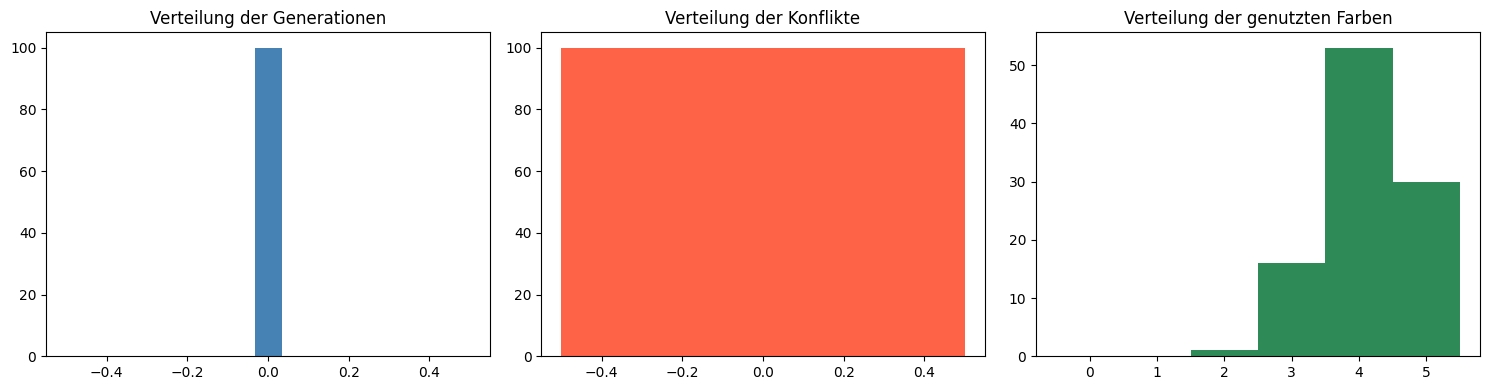

In [204]:
import csv
import numpy as np
import matplotlib.pyplot as plt

# Ergebnisse sammeln
results = []

# === 100 Läufe =============================================
for i in range(100):
    cfg = GAConfig(pop_size=200, max_generations=2000, crossover_rate=0.9,
                   mutation_rate=0.2, tournament_k=3, elitism=2, seed=None)

    fitness_fn = mc_fitness_factory(edges, penalty_used_colors=0.0)
    is_solution_fn = mc_is_solution_factory(edges)

    best, fit, gens, evals, secs = run_ga(
        init_population_fn=lambda: mc_init_population(num_nodes, num_colors, cfg.pop_size),
        fitness_fn=fitness_fn,
        domain_per_index=mc_domain_per_index(num_nodes, num_colors),
        config=cfg,
        is_solution_fn=is_solution_fn,
    )

    conflicts = mc_conflicts(best, edges)
    colors = mc_num_used_colors(best)
    success = int(conflicts == 0)

    # Ergebnisse speichern
    results.append({
        "run_id": i,
        "success": success,
        "gens": gens,
        "evals": evals,
        "secs": secs,
        "fit": fit,
        "conflicts": conflicts,
        "colors_used": colors,
        "best_solution": best
    })

# === Auswertung =============================================
runs = len(results)
succ_rate = sum(r["success"] for r in results) / runs * 100
avg_gens = np.mean([r["gens"] for r in results])
avg_secs = np.mean([r["secs"] for r in results])
avg_fit = np.mean([r["fit"] for r in results])
avg_conf = np.mean([r["conflicts"] for r in results])
avg_colors = np.mean([r["colors_used"] for r in results])

print("\n=== Map Coloring: Auswertung nach", runs, "Läufen ===")
print(f"Erfolgsquote: {succ_rate:.1f}%")
print(f"Ø Generationen: {avg_gens:.1f}")
print(f"Ø Zeit: {avg_secs:.3f}s")
print(f"Ø Fitness: {avg_fit:.2f}")
print(f"Ø Konflikte: {avg_conf:.2f}")
print(f"Ø genutzte Farben: {avg_colors:.2f}")

# === CSV-Export =============================================
csv_file = "results_map_coloring.csv"
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "run_id", "success", "gens", "evals", "secs",
        "fit", "conflicts", "colors_used", "best_solution"
    ])
    for r in results:
        writer.writerow([
            r["run_id"], r["success"], r["gens"], r["evals"],
            r["secs"], r["fit"], r["conflicts"], r["colors_used"], r["best_solution"]
        ])
print(f"\n✅ Ergebnisse gespeichert in: {csv_file}")

# === Optional: Histogramme ==================================
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist([r["gens"] for r in results], bins=15, color="steelblue")
axs[0].set_title("Verteilung der Generationen")

axs[1].hist([r["conflicts"] for r in results],
            bins=range(int(max([r["conflicts"] for r in results]) + 2)),
            color="tomato", align='left')
axs[1].set_title("Verteilung der Konflikte")

axs[2].hist([r["colors_used"] for r in results],
            bins=range(int(max([r["colors_used"] for r in results]) + 2)),
            color="seagreen", align='left')
axs[2].set_title("Verteilung der genutzten Farben")

plt.tight_layout()
plt.show()
